In [1]:
using Distributed
addprocs(44);

In [2]:
using pulse_input_DDM

In [3]:
path = "/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

"/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

In [4]:
#ratnames = ["B068","T034","T036","T063","T030"] #FOF
#ratnames = ["T035","T011","B053"] PPC
#ratnames = ["T080","T103","E021"] #STR

In [5]:
region, rat = "FOF", "T063"

("FOF", "T063")

In [6]:
sessions = filter(x->occursin(rat,x), readdir(path))

17-element Array{String,1}:
 "T063_191956.mat"
 "T063_193936.mat"
 "T063_194554.mat"
 "T063_194649.mat"
 "T063_194770.mat"
 "T063_194898.mat"
 "T063_195271.mat"
 "T063_195546.mat"
 "T063_195676.mat"
 "T063_195791.mat"
 "T063_196336.mat"
 "T063_196580.mat"
 "T063_196708.mat"
 "T063_197075.mat"
 "T063_197212.mat"
 "T063_197479.mat"
 "T063_198004.mat"

In [14]:
output = load.(joinpath.(path, sessions[end-4:end]), false, delay=0.0);

In [15]:
data = getindex.(output, 1)
μ_rnt = getindex.(output, 2);
μ_t = getindex.(output, 3);

In [16]:
f, ncells, ntrials, nparams = "Sigmoid", map(x-> x[1].ncells, data), length.(data), 4

("Sigmoid", [4, 3, 2, 1, 3], [264, 249, 300, 319, 309], 4)

In [17]:
nconds, dt = 2, 1e-2

(2, 0.01)

In [18]:
output = pulse_input_DDM.process_spike_data.(μ_rnt, data, ncells; nconds=nconds);

μ_ct = getindex.(output, 1)
σ_ct = getindex.(output, 2);

In [19]:
using PyPlot

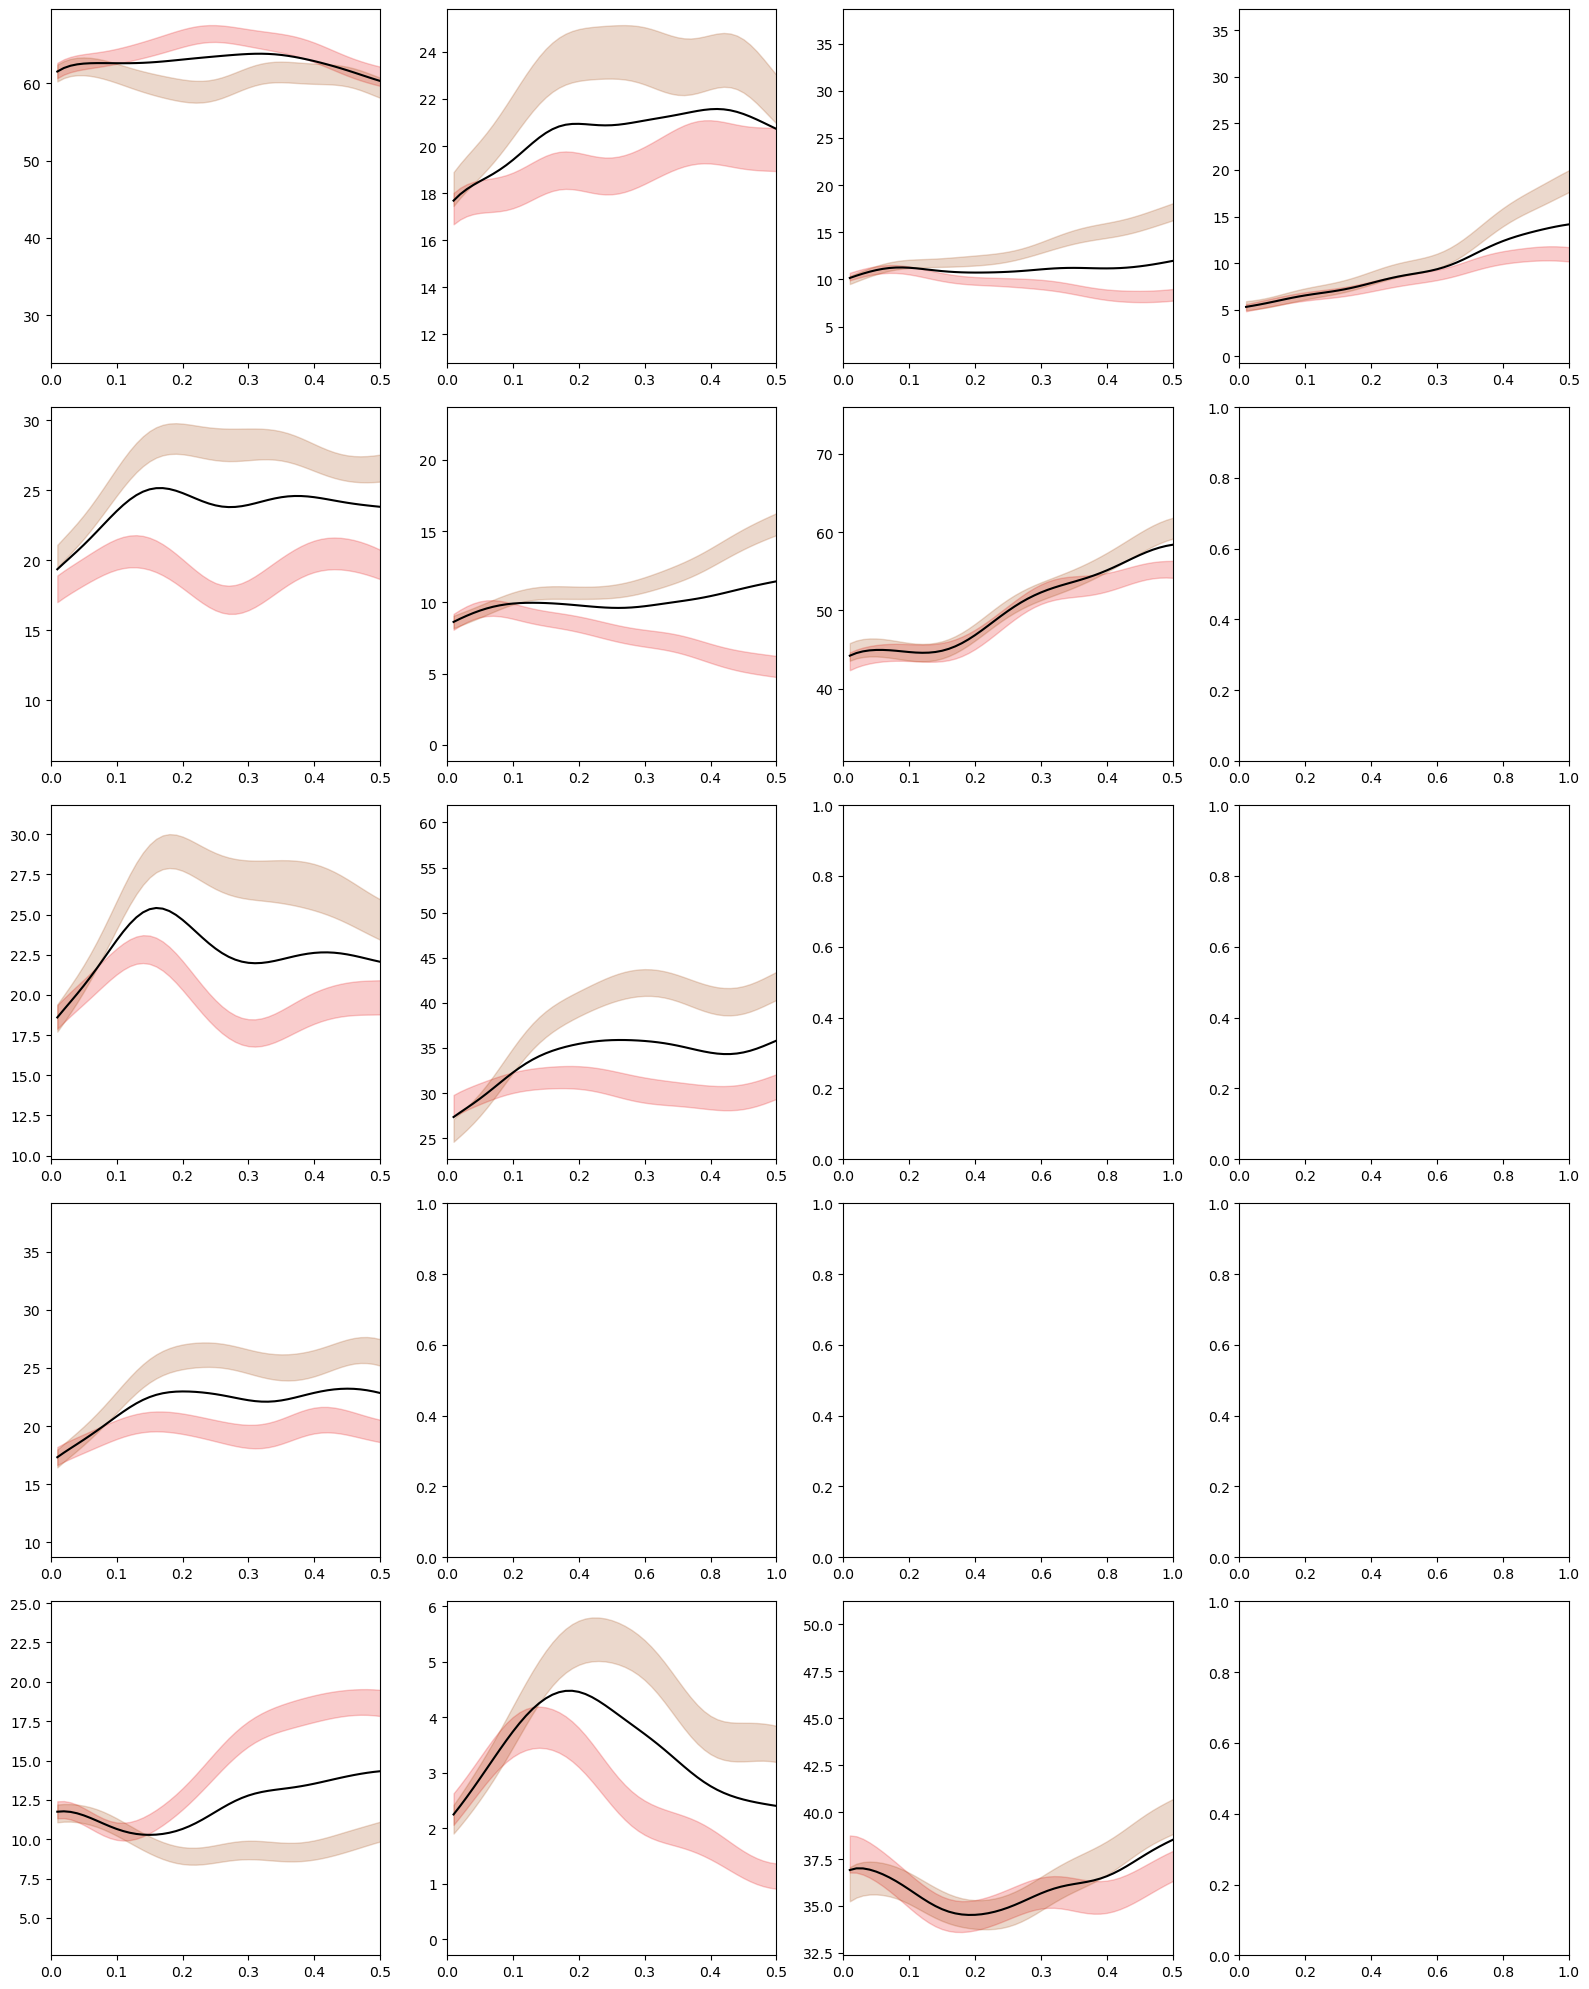

In [20]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]
#PPC colors = ["#1822A0","#5D4A7A","#A37354","#E99C2F"]
#STR colors = ["#A01892","#B85C71","#D0A150","#E9E62F"]

for i in 1:num_rows      
    for j in 1:data[i][1].ncells   
        
        if (num_rows == 1) && (data[i][1].ncells == 1)
        
            for k = 1:nconds   

                ax.fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])                                   

                ax.set_xlim((0, 0.5))

            end   

            ax.plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
            
        elseif (num_rows == 1) && (data[i][1].ncells > 1)
            
            for k = 1:nconds   

                ax[j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])                                  

                ax[j].set_xlim((0, 0.5))

            end   

            ax[j].plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
        elseif num_rows > 1
             
            for k = 1:nconds   

                ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])                                   

                ax[i,j].set_xlim((0, 0.5))

            end   

            ax[i,j].plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
        end

    end
    
end

tight_layout() 

## Fit

In [21]:
θy0 = vcat(vcat(initialize_θy.(data, f)...)...);

In [22]:
options0 = neuraloptions(ncells=ncells,
    fit=vcat(falses(dimz), trues(sum(ncells)*nparams)),
    x0=vcat([0., 30., 0. + eps(), 0., 0., 1. - eps(), 0.008], θy0))

neuraloptions
  ncells: Array{Int64}((5,)) [4, 3, 2, 1, 3]
  nparams: Int64 4
  f: String "Sigmoid"
  fit: Array{Bool}((59,)) Bool[0, 0, 0, 0, 0, 0, 0, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  lb: Array{Float64}((59,)) [0.0, 8.0, -5.0, 0.0, 0.0, 0.01, 0.005, -100.0, 0.0, -10.0  …  -10.0, -10.0, -100.0, 0.0, -10.0, -10.0, -100.0, 0.0, -10.0, -10.0]
  ub: Array{Float64}((59,)) [30.0, 32.0, 5.0, 200.0, 5.0, 1.2, 1.0, 100.0, 100.0, 10.0  …  10.0, 10.0, 100.0, 100.0, 10.0, 10.0, 100.0, 100.0, 10.0, 10.0]
  x0: Array{Float64}((59,)) [0.0, 30.0, 2.220446049250313e-16, 0.0, 0.0, 0.9999999999999998, 0.008, 53.333333333333336, 8.740668614086331, -0.0002924847184625089  …  -0.002245340779347089, 0.0, 0.1, 3.9404951169657054, 0.0005687069143647916, 0.0, 36.29113575946466, 9.71525401689317, 0.001225733958446602, 0.0]


In [24]:
model, = optimize(data, options0; show_trace=false)

optimization complete. converged: true 



(neuralDDM{θneural{θz{Float64},Array{Array{Sigmoid{Float64},1},1}},Array{Array{neuraldata,1},1}}
  θ: θneural{θz{Float64},Array{Array{Sigmoid{Float64},1},1}}
  data: Array{Array{neuraldata,1}}((5,))
,  * Status: success

 * Candidate solution
    Minimizer: [-8.62e-01, 3.43e+01, 1.48e-05,  ...]
    Minimum:   1.730170e+05

 * Found with
    Algorithm:     Fminbox with BFGS
    Initial Point: [5.33e+01, 8.74e+00, -2.92e-04,  ...]

 * Convergence measures
    |x - x'|               = 2.21e-02 ≰ 1.0e-10
    |x - x'|/|x'|          = 2.05e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.33e-02 ≰ 1.0e-06
    |f(x) - f(x')|/|f(x')| = 7.70e-08 ≰ 0.0e+00
    |g(x)|                 = 1.21e+00 ≰ 1.0e-03

 * Work counters
    Seconds run:   91  (vs limit Inf)
    Iterations:    2
    f(x) calls:    458
    ∇f(x) calls:   133
)

In [29]:
model.θ.θy

5-element Array{Array{Sigmoid{Float64},1},1}:
 [Sigmoid{Float64}
  a: Float64 -0.8621940603635148
  b: Float64 34.32595070458168
  c: Float64 1.4784073882298531e-5
  d: Float64 -3.6883301776664172
, Sigmoid{Float64}
  a: Float64 -6.496863475003831
  b: Float64 38.69863704774069
  c: Float64 -2.0930179284629668e-5
  d: Float64 -1.5942683570954805
, Sigmoid{Float64}
  a: Float64 -0.0655835829284811
  b: Float64 31.814957305225146
  c: Float64 -0.00014756512333351736
  d: Float64 -5.773717883870001
, Sigmoid{Float64}
  a: Float64 -0.021403366475267183
  b: Float64 29.674782441374603
  c: Float64 -0.00012731376561922364
  d: Float64 -9.02887506019525
]
 [Sigmoid{Float64}
  a: Float64 -0.3393805500687683
  b: Float64 30.481632286259856
  c: Float64 -5.727697694068027e-5
  d: Float64 -4.681839381756106
, Sigmoid{Float64}
  a: Float64 -6.4422739252672985
  b: Float64 25.28039541272621
  c: Float64 -0.0001594390335357283
  d: Float64 -1.072337499540203
, Sigmoid{Float64}
  a: Float64 -0.495946

In [31]:
fit=vcat(falses(1), trues(dimz-1), trues(sum(ncells)*nparams))
#x0=vcat([0.1, 12., -2., 10., 0.1, 0.8, 0.008], θy0);
x0=vcat([0.1, 12., -2., 10., 0.1, 0.8, 0.008], pulse_input_DDM.flatten(model.θ)[dimz+1:end]);

In [32]:
options = neuraloptions(ncells=ncells, x0=x0, fit=fit, nparams=nparams, f=f);

In [33]:
n = 53

53

In [ ]:
model, = optimize(data, options, n);

Fminbox
-------
Initial mu = 0.0136739

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0136739

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.730130e+05     2.934240e+03
 * time: 3.504753112792969e-5
     1     1.728759e+05     1.676594e+03
 * time: 28.387665033340454
     2     1.728015e+05     2.448864e+02
 * time: 40.4626669883728
     3     1.726979e+05     3.422410e+02
 * time: 52.56877517700195
     4     1.726582e+05     6.219984e+02
 * time: 63.89617919921875
     5     1.726257e+05     1.216137e+02
 * time: 80.16861009597778
     6     1.726109e+05     1.122333e+02
 * time: 96.3210940361023
     7     1.725365e+05     1.848404e+02
 * time: 112.65847110748291
     8     1.725166e+05     2.756212e+02
 * time: 128.91189408302307
     9     1.724887e+05     3.645238e+02
 * time: 139.72414898872375
    10     1.724571e+05     4.383490e+02
 * time: 150.55213499069214
    11     1.724498e+05     4.57415

In [ ]:
model.θ.θz

In [ ]:
model.θ.θy

## Sample rates

In [125]:
μ_λ, μ_c_λ = pulse_input_DDM.synthetic_λ(model.θ, data; num_samples=100, nconds=nconds);

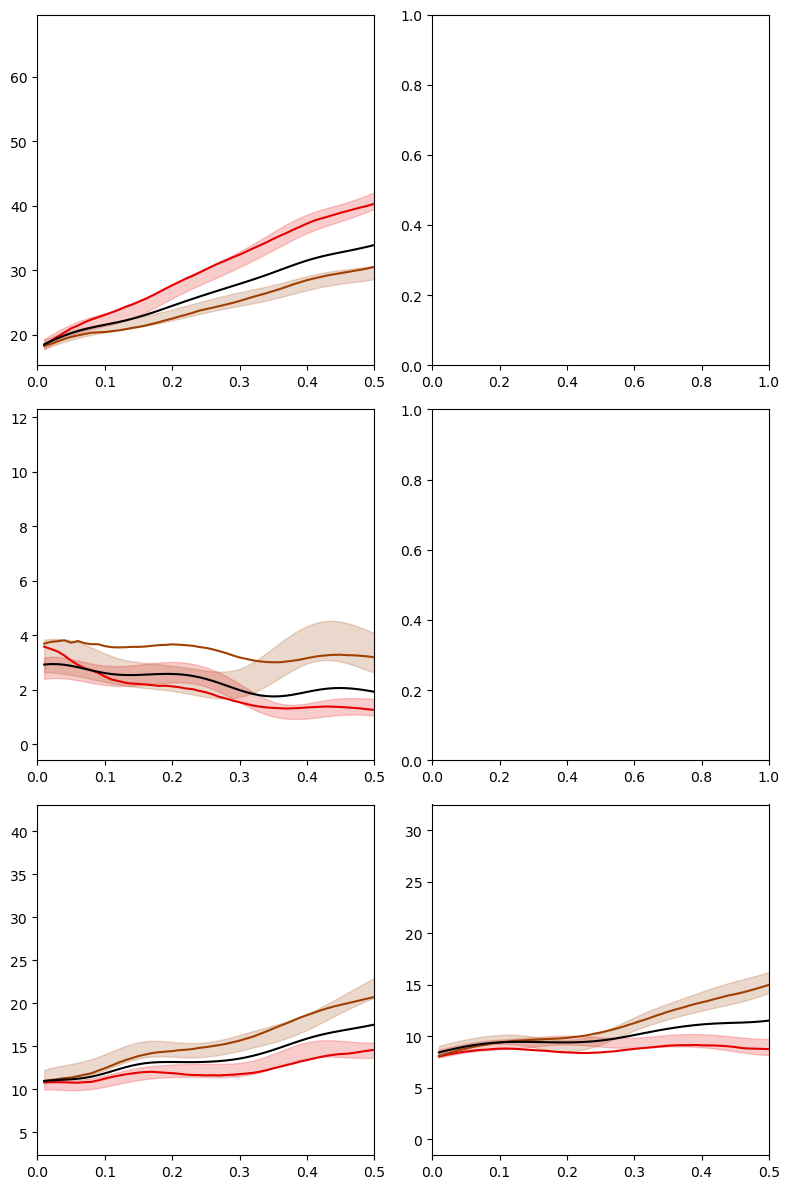

In [126]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]
#PPC colors = ["#1822A0","#5D4A7A","#A37354","#E99C2F"]
#STR colors = ["#A01892","#B85C71","#D0A150","#E9E62F"]

for i in 1:num_rows      
    for j in 1:data[i][1].ncells   
        
        if (num_rows == 1) && (data[i][1].ncells == 1)
        
            for k = 1:nconds   

                ax.fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k]) 
                
                ax.plot((1:length(μ_c_λ[i][j][k]))*dt,
                    μ_c_λ[i][j][k], color=my_colors[k])  

                ax.set_xlim((0, 0.5))

            end   

            ax.plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
            
        elseif (num_rows == 1) && (data[i][1].ncells > 1)
            
            for k = 1:nconds   

                ax[j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])  
                
                ax[j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                    μ_c_λ[i][j][k], color=my_colors[k])  

                ax[j].set_xlim((0, 0.5))

            end   

            ax[j].plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
        elseif num_rows > 1
             
            for k = 1:nconds   

                ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k]) 
                
                ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                    μ_c_λ[i][j][k], color=my_colors[k])  

                ax[i,j].set_xlim((0, 0.5))

            end   

            ax[i,j].plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
        end

    end
    
end

tight_layout() 

## Model fit

In [127]:
LL_ML = loglikelihood(model.θ, data, n)

-26359.565575318018

In [128]:
LL_null = mapreduce((data,θy)-> mapreduce(data-> mapreduce(n->
    pulse_input_DDM.neural_null(data.spikes[n], θy[n]([0.], data.input_data.λ0[n]), dt),
        +, 1:data.ncells), +, data), +, data, model.θ.θy)

-26826.233518659978

In [129]:
LL_ML - LL_null

466.6679433419595

In [130]:
SSx(x, nT) = sum(sum.(map(x-> x[1:nT].^2, vcat(vcat((x)...)...)))) 

SSx (generic function with 1 method)

In [131]:
1 - SSx(μ_c_λ - μ_ct, 40)/SSx(μ_ct, 40)

0.9984242988598551

### Compute Hessian
Blah blah blah

In [132]:
H = Hessian(model, n)
CI, HPSD = CIs(H);

┌ Warning: Hessian is not positive definite. Approximated by closest PSD matrix.
│             ||ϵ||/||H|| is 2.0001792358403874
└ @ pulse_input_DDM /usr/people/briandd/Projects/pulse_input_DDM/src/base_model.jl:19


In [134]:
CI

23-element Array{Float64,1}:
  0.9441700876724042  
 26.01371583368999    
  2.0292347871862755  
  3.967950808360353e-6
  1.9342156663363548  
  0.4226188487253502  
  0.15516667612718352 
  1.9760912173871845  
  3.485424556181545   
  0.6933494780904812  
  0.5775911614555912  
  0.73969907256465    
  0.9941847217422379  
 17.29185980703016    
 11.616858661343226   
  1.4615215836549809  
  2.5662890437999026  
  0.41978713930159545 
  0.508239640332584   
 28.53473329654997    
  1.9999999999999991  
  0.02773288901197558 
  1.2417697758474575  